<a href="https://colab.research.google.com/github/CheshireCat12/Deep_learning_challenges/blob/master/classifier_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
BATCH_SIZE = 32

In [0]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [0]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

In [0]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(32, 8, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layers_fc = nn.Sequential(
            nn.Linear(8*7*7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        output = self.layers_fc(x)
        
        return output, x
        

In [122]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn = CNN()

cnn.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers_fc): Sequential(
    (0): Linear(in_features=392, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_featu

In [0]:
def train(model, train_dataloader, val_dataloader, optimizer, nb_epochs, loss_func):
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(nb_epochs):
        ## Training phase
        model.train()
        
        losses = []
        correct_train_pred = 0
        
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            output, _ = model(images)
            
            optimizer.zero_grad()
            loss = loss_func(output, labels)
            
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            predicted_labels = output.argmax(dim=1)
            nb_correct = (predicted_labels==labels).sum().item()
            correct_train_pred += nb_correct
        
        train_losses.append(np.mean(np.array(losses)))
        train_accuracies.append(100*correct_train_pred/len(train_dataloader.dataset))
            
            
        model.eval()
        correct_val_pred = 0
        losses = []
        
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                
                output, _ = model(images)
                
                loss = loss_func(output, labels)
                
                losses.append(loss.item())
                
                predicted_labels = output.argmax(dim=1)
                nb_correct = (predicted_labels==labels).sum().item()
                correct_val_pred += nb_correct
                
        val_losses.append(np.mean(np.array(losses)))        
        val_accuracies.append(100*correct_val_pred/len(val_dataloader.dataset))
        
        print(f'Epoch: {epoch+1}/{nb_epochs} |\
                Train_loss: {train_losses[-1]:.4f} |\
                Train_acc: {train_accuracies[-1]:.4f} |\
                Val_loss: {val_losses[-1]:.4f} |\
                Val_acc: {val_accuracies[-1]:-4f}')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [123]:
nb_epochs = 30
#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(cnn.parameters())
loss_func = nn.CrossEntropyLoss()

import time

start = time.time()

train_loss, train_acc, val_loss, val_acc = train(cnn,
                                                 train_loader,
                                                 test_loader,
                                                 optimizer,
                                                 nb_epochs,
                                                 loss_func)

end = time.time()

print(f'Execution time : {(end-start)/60}')

Epoch: 1/30 |                Train_loss: 0.3957 |                Train_acc: 87.4100 |                Val_loss: 0.0690 |                Val_acc: 97.930000
Epoch: 2/30 |                Train_loss: 0.1163 |                Train_acc: 96.8883 |                Val_loss: 0.0503 |                Val_acc: 98.540000
Epoch: 3/30 |                Train_loss: 0.0888 |                Train_acc: 97.6183 |                Val_loss: 0.0437 |                Val_acc: 98.860000
Epoch: 4/30 |                Train_loss: 0.0761 |                Train_acc: 97.9400 |                Val_loss: 0.0442 |                Val_acc: 98.720000
Epoch: 5/30 |                Train_loss: 0.0662 |                Train_acc: 98.2350 |                Val_loss: 0.0367 |                Val_acc: 98.910000
Epoch: 6/30 |                Train_loss: 0.0596 |                Train_acc: 98.3650 |                Val_loss: 0.0370 |                Val_acc: 98.990000
Epoch: 7/30 |                Train_loss: 0.0527 |                Train_acc: 

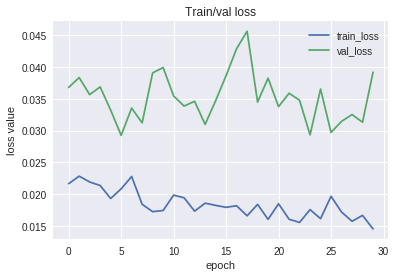

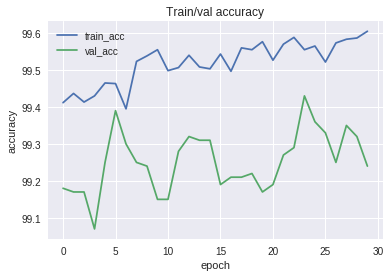

In [125]:
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(np.arange(n_epochs), train_losses)
    plt.plot(np.arange(n_epochs), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss');

    plt.figure()
    plt.plot(np.arange(n_epochs), train_accuracies)
    plt.plot(np.arange(n_epochs), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy');

plot(nb_epochs, train_loss, val_loss, train_acc, val_acc)